### Importing Modules

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as sts
from scipy.stats import skew
import seaborn as sns
import matplotlib.dates as dates

### Excess returns

In order to perform a robust analysis on your portfolio returns, you must first subtract the risk-free rate of return from your portfolio returns. The portfolio return minus the risk-free rate of return is known as the Excess Portfolio Return.

In the United States, the risk-free rate has been close to 0 since the financial crisis (2008), but this step is crucial for other countries with higher risk-free rates such as Venezuela or Brazil.

In [2]:
FamaFrenchData = pd.read_csv("FamaFrenchFactors.csv")

In [4]:
FamaFrenchData.head()

,Date,Portfolio,Market_Excess,SMB,HML,RMW,CMA,RF
0,2013-01-03,-0.005066,-0.0014,0.0014,0.0004,0.0020,0.0023,0.0
1,2013-01-04,0.004024,0.0055,0.0019,0.0043,-0.0037,0.0027,0.0
2,2013-01-07,0.004421,-0.0031,-0.0009,-0.0037,-0.0013,-0.0012,0.0
3,2013-01-08,-0.004659,-0.0027,0.0004,-0.0007,-0.0012,0.0009,0.0
4,2013-01-09,0.004636,0.0034,0.0024,-0.0041,-0.0007,-0.0015,0.0


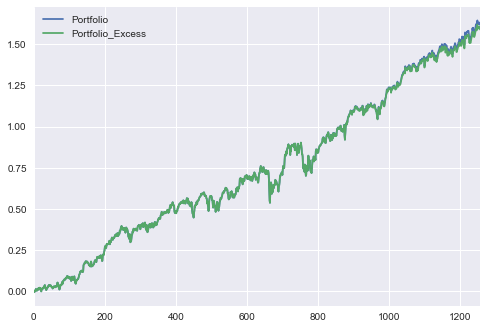

In [5]:
# Calculate excess portfolio returns
FamaFrenchData['Portfolio_Excess'] = FamaFrenchData['Portfolio'] - FamaFrenchData['RF']

# Plot returns vs excess returns
CumulativeReturns = ((1+FamaFrenchData[['Portfolio','Portfolio_Excess']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

### Calculating beta using co-variance

Beta is an essential component of many financial models, and is a measure of systematic risk, or exposure to the broad market. In the CAPM model, beta is one of two essential factors.

Historical beta can be estimated in a number of ways. In this exercise, you will use the following simple formula involving co-variance and variance to a benchmark market portfolio:

βP=Cov(RP,RB)Var(RB)

βP: Portfolio beta

Cov(RP,RB): The co-variance between the portfolio (P) and the benchmark market index (B)

Var(RB): The variance of the benchmark market index

##### Generate a co-variance matrix between 'Portfolio_Excess' and 'Market_Excess' columns.

In [6]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

5.72612633815e-05


#### Calculate the variance of 'Market_Excess' column.

In [7]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
print(benchmark_variance)

5.72612633815e-05
5.8803350882118946e-05


#### calculate portfolio beta

In [8]:
# Calculate the co-variance matrix between Portfolio_Excess and Market_Excess
covariance_matrix = FamaFrenchData[['Portfolio_Excess', 'Market_Excess']].cov()

# Extract the co-variance co-efficient
covariance_coefficient = covariance_matrix.iloc[0, 1]
print(covariance_coefficient)

# Calculate the benchmark variance
benchmark_variance = FamaFrenchData['Market_Excess'].var()
print(benchmark_variance)

# Calculating the portfolio market beta
portfolio_beta = covariance_coefficient / benchmark_variance
print(portfolio_beta)

5.72612633815e-05
5.8803350882118946e-05
0.973775516575


### Calculating beta with CAPM

There are many ways to model stock returns, but the Capital Asset Pricing Model, or CAPM, is one the most well known:

E(RP)−RF=βP(E(RM)−RF) 

E(RP)−RF: The excess expected return of a stock or portfolio P

E(RM)−RF: The excess expected return of the broad market portfolio B

RF: The regional risk free-rate

βP: Portfolio beta, or exposure, to the broad market portfolio B

You can call the .fit() method from statsmodels.formula.api on an .ols(formula, data) model object to perform the analysis, and the .summary() method on the analysis object to anaylze the results.

In [9]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
CAPM_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess', data=FamaFrenchData)

# Fit the regression
CAPM_fit = CAPM_model.fit()
print(CAPM_fit.rsquared_adj)

# Extract the beta
regression_beta = CAPM_fit.params['Market_Excess']
print(regression_beta)

0.794262716002
0.973775516575


### The Fama French 3-factor model

The Fama-French model famously adds two additional factors to the CAPM model to describe asset returns:

RP=RF+βM(RM−RF)+bSMB⋅SMB+bHML⋅HML+α

SMB: The small minus big factor

bSMB: Exposure to the SMB factor

HML: The high minus low factor

bHML: Exposure to the HML factor

α: Performance which is unexplained by any other factors

βM: Beta to the broad market portfolio B

In [10]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
FamaFrench_model = smf.ols(formula='Portfolio_Excess ~ Market_Excess + SMB + HML', data=FamaFrenchData)

# Fit the regression
FamaFrench_fit = FamaFrench_model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = FamaFrench_fit.rsquared_adj
print(regression_adj_rsq)

0.819391008859


### p-values and coefficients

You can use the .pvalues attribute on a fitted smf.ols regression model to retrieve the p-values for each coefficient.

Normally, p-values less than 0.05 are considered statistically significant.

Coefficients can be extracted from the fitted regression object using the .params attribute.

In this example, a statistically significant negative SMB ('Small Minus Big') coefficient would signify a factor exposure to large cap stocks, while a positive coefficient would signify an exposure to small cap stocks.

In [12]:
# Extract the p-value of the SMB factor
smb_pval = FamaFrench_fit.pvalues['SMB']

# If the p-value is significant, print significant
if smb_pval < 0.05:
    significant_msg = 'significant'
else:
    significant_msg = 'not significant'

# Print the SMB coefficient
smb_coeff = FamaFrench_fit.params['SMB']
print("The SMB coefficient is ", smb_coeff, " and is ", significant_msg)

The SMB coefficient is  -0.262151527432  and is  significant


### The efficient market and alpha

The alpha (α) left over by the regression is unexplained performance due to unknown factors. In a regression model, this is simply the coefficient of the intercept.

There are two general schools of thought as to why:

The model simply needs to be expanded. When you have found all of the missing economic factors, you can explain all stock and portfolio returns. This is known as the Efficient Market Hypothesis.

There is a degree of unexplainable performance that no model will ever capture reliably. Perhaps it is due to skill, timing, intuition or luck, but investors should seek to maximize their alpha.

In [13]:
# Extract your portfolio alpha
portfolio_alpha = FamaFrench_fit.params['Intercept']
print(portfolio_alpha)

# Annualize your portfolio alpha
portfolio_alpha_annualized = ((1+portfolio_alpha)**252)-1
print(portfolio_alpha_annualized)

0.000183266652032
0.0472618173028
